In [ ]:
import keras
import tensorflow as tf
import cv2
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


- **NOTES**: `image_dataset_from_directory` will automatically zero-pad and resize the images based on the `image_size` parameter provided. VGG16 takes in images of shape `(224,224)` for each channel.

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    '/content/gdrive/My Drive/data/images/',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=None,
    image_size=(224, 224),
    seed=2022,
    validation_split=0.30,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

val = tf.keras.utils.image_dataset_from_directory(
    '/content/gdrive/My Drive/data/images/',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=None,
    image_size=(224, 224),
    seed=2022,
    validation_split=0.30,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

'''
Splitting image dataset into train, test and validation
https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
'''
test_size = int(len(val)*0.5)
test = val.take(test_size)
val = val.skip(test_size)
print('Train size:', len(train))
print('Validation size:', len(val))
print('Test size:', len(test))
train = train.batch(32)
val = val.batch(32)
test = test.batch(176)

Found 1176 files belonging to 20 classes.
Using 824 files for training.
Found 1176 files belonging to 20 classes.
Using 352 files for validation.
Train size: 824
Validation size: 176
Test size: 176


- **NOTES**: Set `model.trainable` to `False` to use the pretrained weights for Transfer learning.

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
vgg.trainable = False
# print(vgg.summary())

efficientNet = EfficientNetB0(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
efficientNet.trainable = False
# print(efficientNet.summary())

- **NOTES**: Keras comes with a decent set of image augmentation methods for Flip, Rotation, Zoom, Contrast. We can use them as a layer in our Sequential Keras model.
- **OBSERVATION**: Cropping and translating the images using the `tf.keras.layers.RandomTranslation` & `tf.keras.layers.RandomCrop` is not helping and is hurting the model performance. Hence, they are not present 



In [ ]:
image_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

- **NOTES**: Setting batch size to 32, as batch size of 5 is performing poorly on the test set.

In [ ]:
model = tf.keras.Sequential([
    image_augmentation,
    vgg,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='softmax')
])

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

model_hist = model.fit(train, epochs=100, validation_data = val, callbacks=[earlyStopping])

Epoch 1/100
26/26 [==============================] - 20s 365ms/step - loss: 3.6110 - accuracy: 0.2209 - val_loss: 9.9120 - val_accuracy: 0.3920
Epoch 2/100
26/26 [==============================] - 11s 343ms/step - loss: 2.0198 - accuracy: 0.5255 - val_loss: 6.7745 - val_accuracy: 0.4659
Epoch 3/100
26/26 [==============================] - 11s 340ms/step - loss: 1.5897 - accuracy: 0.6214 - val_loss: 4.6562 - val_accuracy: 0.5227
Epoch 4/100
26/26 [==============================] - 11s 337ms/step - loss: 1.3453 - accuracy: 0.6748 - val_loss: 4.1203 - val_accuracy: 0.5682
Epoch 5/100
26/26 [==============================] - 12s 381ms/step - loss: 1.1325 - accuracy: 0.7257 - val_loss: 3.7018 - val_accuracy: 0.6023
Epoch 6/100
26/26 [==============================] - 11s 344ms/step - loss: 0.9680 - accuracy: 0.7306 - val_loss: 2.6668 - val_accuracy: 0.6364
Epoch 7/100
26/26 [==============================] - 11s 339ms/step - loss: 0.8945 - accuracy: 0.7670 - val_loss: 2.8151 - val_accuracy:

In [ ]:
print('Test set results for VGG16')

for test_ in test:
    test_features, test_labels = test_
    test_labels_predicted = tf.one_hot(tf.argmax(model.predict(test_features), axis = 1), depth = 20)
    test_labels_predicted = test_labels_predicted.numpy()
    test_labels = test_labels.numpy()
    print(classification_report(test_labels, test_labels_predicted))

Test set results for VGG16
6/6 [==============================] - 1s 144ms/step
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.70      0.88      0.78         8
           2       0.64      0.54      0.58        13
           3       0.62      0.56      0.59         9
           4       0.83      0.62      0.71         8
           5       0.73      0.62      0.67        13
           6       0.62      0.71      0.67         7
           7       0.33      1.00      0.50         2
           8       0.60      0.30      0.40        10
           9       0.80      0.89      0.84         9
          10       0.62      0.71      0.67         7
          11       0.73      1.00      0.84         8
          12       0.90      0.69      0.78        13
          13       0.67      0.71      0.69        14
          14       0.31      0.44      0.36         9
          15       0.75      0.38      0.50         8
 

In [ ]:
model2 = tf.keras.Sequential([
    image_augmentation,
    efficientNet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='softmax')
])

model2.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
earlyStopping2 = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

model2_hist = model2.fit(train, epochs=100, validation_data = val, callbacks=[earlyStopping2])

Epoch 1/100
26/26 [==============================] - 19s 314ms/step - loss: 6.5871 - accuracy: 0.3325 - val_loss: 4.0107 - val_accuracy: 0.6250
Epoch 2/100
26/26 [==============================] - 9s 252ms/step - loss: 4.1667 - accuracy: 0.5850 - val_loss: 3.0413 - val_accuracy: 0.7273
Epoch 3/100
26/26 [==============================] - 9s 247ms/step - loss: 3.0158 - accuracy: 0.7002 - val_loss: 2.3936 - val_accuracy: 0.7727
Epoch 4/100
26/26 [==============================] - 9s 257ms/step - loss: 2.2041 - accuracy: 0.7779 - val_loss: 1.9155 - val_accuracy: 0.8011
Epoch 5/100
26/26 [==============================] - 9s 252ms/step - loss: 2.3478 - accuracy: 0.7949 - val_loss: 2.6337 - val_accuracy: 0.7670
Epoch 6/100
26/26 [==============================] - 9s 260ms/step - loss: 1.7673 - accuracy: 0.8095 - val_loss: 2.4914 - val_accuracy: 0.8068
Epoch 7/100
26/26 [==============================] - 9s 260ms/step - loss: 1.7512 - accuracy: 0.8265 - val_loss: 2.7752 - val_accuracy: 0.772

In [ ]:
print('Test set results for EfficientNetB0')

for test_ in test:
    test_features, test_labels = test_
    test_labels_predicted = tf.one_hot(tf.argmax(model.predict(test_features), axis = 1), depth = 20)
    test_labels_predicted = test_labels_predicted.numpy()
    test_labels = test_labels.numpy()
    print(classification_report(test_labels, test_labels_predicted))

Test set results for EfficientNetB0
6/6 [==============================] - 1s 143ms/step
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.92      0.69      0.79        16
           2       0.73      0.73      0.73        11
           3       0.67      0.44      0.53         9
           4       0.60      0.60      0.60         5
           5       0.46      0.67      0.55         9
           6       0.75      0.75      0.75         4
           7       0.89      0.80      0.84        10
           8       0.60      0.38      0.46         8
           9       0.83      0.62      0.71         8
          10       0.67      0.75      0.71         8
          11       0.64      1.00      0.78         7
          12       0.80      0.57      0.67         7
          13       0.69      0.75      0.72        12
          14       0.38      0.50      0.43         6
          15       0.50      0.33      0.40   

Plot the training and validation errors vs. epochs.

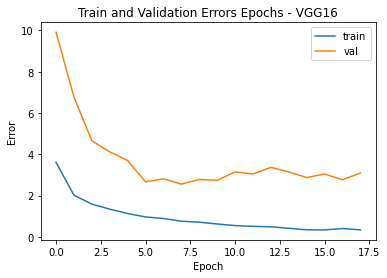

In [ ]:
plt.plot(model_hist.history["loss"])
plt.plot(model_hist.history['val_loss'])
plt.title('Train and Validation Errors Epochs - VGG16')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='auto')
plt.show()

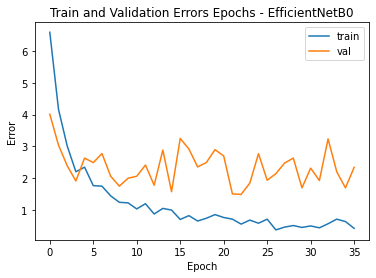

In [ ]:
plt.plot(model2_hist.history['loss'])
plt.plot(model2_hist.history['val_loss'])
plt.title('Train and Validation Errors Epochs - EfficientNetB0')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='auto')
plt.show()